Bayesian GPLVM
--
This notebook shows how to use the Bayesian GPLVM model.

In [1]:
from __future__ import print_function
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data
Install the oil dataset.

In [2]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Acquiring resource: three_phase_oil_flow

Details of data: 
The three phase oil data used initially for demonstrating the Generative Topographic mapping.

Please cite:
Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593

After downloading the data will take up 712796 bytes of space.

Data will be stored in /home/vincent/ods_data_cache/three_phase_oil_flow.

[==============================]   0.050/0.050MB                                                                                                                                                                                                                                                                                                                                                
[==============================]   0.196/0.196MB                                                                    

'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using additive kernel.

In [ ]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) + 
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) + 
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))
    
m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m)#, options=dict(disp=True, maxiter=100))

/home/vincent/.virtualenvs/gpflow/lib/python3.5/site-packages/gpflow/kernels.py:229: UserWarning: Using numerical quadrature for kernel expectation of <class 'gpflow.kernels.Add'>. Use gpflow.ekernels instead.
  str(type(self)))
/home/vincent/.virtualenvs/gpflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 1600000000 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

<Parameter name:BayesianGPLVM/kern/linear/variance [trainable] prior:None transform:+ve shape:()>
value: 1.002394024753348e-06

<Parameter name:BayesianGPLVM/kern/rbf/variance [trainable] prior:None transform:+ve shape:()>
value: 0.9810831852564732

<Parameter name:BayesianGPLVM/kern/rbf/lengthscales [trainable] prior:None transform:+ve shape:(3,)>
value: [ 4.87448121,  1.28690379,  3.51281023]
[ 0.20320038  0.76967404  0.28196696]


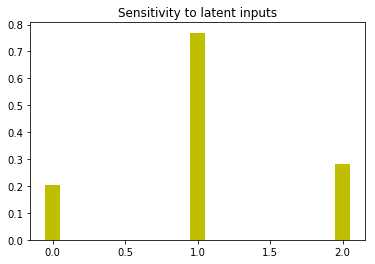

In [10]:
kern = m.kern.kern_list[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(m.kern)
print(sens)
fig, ax = plt.subplots()
ax.bar(np.arange(len(kern.lengthscales.read_value())) , sens, 0.1, color='y')
ax.set_title('Sensitivity to latent inputs')

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

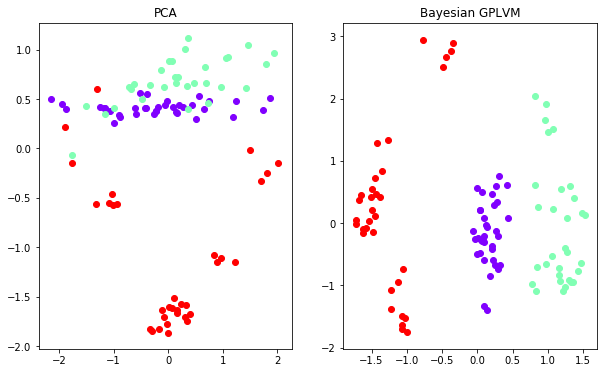

In [13]:
XPCAplot = gpflow.models.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,2, figsize=(10,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(m.X_mean.read_value()[labels==i,1], m.X_mean.read_value()[labels==i,2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
    